In [1]:
# A simpler approach would be not to do this preprocessing and do replay including releases
# Avoiding hoykey, double clicks and drags detections 
class Preprocessing():
    def __init__(self, length_th, minpixels_th, dt_th, maxpixels_th): 
        # The thresholds for drag and doubleclicks detection determine the correct replay of task, how important are to calibrate them? 
        # Many of these functions make copies of dataframe, so it is not efficient. 
        # Drags
        self.length_th = length_th 
        self.minpixels_th = minpixels_th
        # Double clicks
        self.dt_th = dt_th 
        self.maxpixels_th = maxpixels_th

    def run(self, sample): 
        s1 = sample.copy()                                                             
        s1['trajectory'] = s1['trajectory'].map(lambda x: self.string2list(x))      # Convert a list represented as a string into a actual list
        s1 = self.replace_drags(s1)                                                 # Detect drag events
        s1 = self.replace_doubleclicks(s1)                                          # Detect doubleclicks
        s1 = self.replace_hotkeys(s1)                                               # Detect hotkeys and combinations
        s1 = s1[s1['event'].map(lambda x: ('pressed' in x) or ('Scroll.' in x))].copy()   # Select pressed and scroll events
        s1['event'] = s1['event'].map(lambda x: x.replace('pressed ',''))                 # Remove pressed string
        delays = s1['timestamp'][1:].values - s1['timestamp'][0:-1].values                # Calculating delays
        delays = np.append(delays,0.0)                                                
        s1['delay'] = delays
        actions = s1.reset_index(drop=True)                                     # Reset dataframe index
        return actions
    
    def replace_hotkeys(self, sample):
        """ Replace rows in the sample by hotkey events """
        # The key insight: consecutive pressed events form a hotkey. 
        # And the number of releases (di) between groups of consective pressed events determine the keys that are keeping press (basepressed). 
        # Note: Remove their corresponding releases
        samplecopy = sample.copy()
        samplecopy = samplecopy.reset_index(drop=True) 
        for ix, ixN in self.find_hotkeys(samplecopy):
            ixs_pressed = samplecopy.loc[ix:ixN].index[samplecopy.loc[ix:ixN,'event'].map(lambda x: 'pressed' in x)].tolist()
            pgroups = self.group_consecutive(ixs_pressed)  # Groups of consecutive position indexes of pressed events
            keep_ixs = []
            basepressed = []
            for i in range(len(pgroups)): 
                pgroup = basepressed + pgroups[i]
                newevent = 'pressed ' + samplecopy.loc[pgroup[0], 'event'].replace('pressed ', '')
                for ki in pgroup[1:]: 
                    newevent += '+' + samplecopy.loc[ki, 'event'].replace('pressed ', '')
                samplecopy.loc[pgroup[-1], 'event'] = newevent
                keep_ixs.append(pgroup[-1])
                if i+1 < len(pgroups):
                    di = pgroups[i+1][0] - pgroup[-1] - 1
                    basepressed = pgroup[:-di]
            # Remove rows
            remove_ixs = [i for i in range(ix,ixN+1)]
            [remove_ixs.remove(i) for i in keep_ixs]
            samplecopy = samplecopy.drop(remove_ixs)
        return samplecopy 
    
    def group_consecutive(self, numbers):
        """ Making groups of consecutive numbers """ # numbers list cannot be empty by design.
        groups = []
        current_group = [numbers[0]]
        for i in range(1, len(numbers)):
            if numbers[i] == numbers[i-1] + 1:
                current_group.append(numbers[i])
            else:
                groups.append(current_group)
                current_group = [numbers[i]]
        groups.append(current_group)
        return groups
    
    def find_hotkeys(self, sample):
        ixs_pressed = sample.index[sample['event'].map(lambda x: 'pressed' in x)].tolist()
        hotkeys_indexes = []
        while len(ixs_pressed) >= 2:  # To not include the end Key.esc
            ix = ixs_pressed[0]
            released1 = sample['event'][ix].replace('pressed', 'released')
            ixN = sample.loc[ix:].index[sample.loc[ix:,'event'] == released1][0]
            if ixN - ix >= 3:  # 3 para evitar que al escribir aparezcan hotkeys. Cuidado!! es una condicion debil
                hotkeys_indexes.append((ix, ixN))
            for i in range(ix,ixN):
                try: 
                    ixs_pressed.remove(i)
                except:
                    pass
        return hotkeys_indexes

    def string2list(self, string): 
        """ Convert the trajectory string into an actual python list"""
        if isinstance(string, str):
            aux1 = string.strip('][').split('), (')
            if aux1[0] != '':
                aux2 = [x.strip(')(').split(', ') for x in aux1]
                trajectory = [(float(time), int(px), int(py)) for time,px,py in aux2]
            else:
                trajectory = []
        else:
            trajectory = []
        return trajectory

    def replace_drags(self, sample):
        """ Transform the dataframe to encode drag events"""
        samplecopy = sample.copy()
        samplecopy['drag2px'] = len(samplecopy)*[None]
        samplecopy['drag2py'] = len(samplecopy)*[None]
        for ix in self.find_drags(sample):
            samplecopy.loc[ix, 'event'] = 'pressed Button.left.drag'
            samplecopy.loc[ix+1, 'event'] = 'released Button.left.drag'
            samplecopy.loc[ix, 'drag2px'] = sample.loc[ix+1, 'px']
            samplecopy.loc[ix, 'drag2py'] = sample.loc[ix+1, 'py']
            samplecopy.at[ix, 'trajectory'] = sample.loc[ix+1, 'trajectory']
            samplecopy.at[ix+1, 'trajectory'] = []
        return samplecopy
    
    def find_drags(self, sample):
        rBleft_indexes = sample.index[sample['event'].map(lambda x: 'released Button.left' == x)]
        drags_indexes = []
        for ix in rBleft_indexes:
            length = len(sample.loc[ix,'trajectory'])
            p1 = (sample.loc[ix-1,'px'],sample.loc[ix-1,'py'])
            p2 = (sample.loc[ix,'px'], sample.loc[ix,'py'])
            if (length >= self.length_th) and ((abs(p1[0]-p2[0]) >= self.minpixels_th) or (abs(p1[1] - p2[1]) >= self.minpixels_th)): 
                drags_indexes.append(ix-1)
        return drags_indexes
    
    def replace_doubleclicks(self, sample):
        """ Transform the dataframe to encode double events """
        samplecopy = sample.copy()
        for ix0,ix1 in self.find_doubleclicks(sample):
            samplecopy.loc[ix0, 'event'] = 'pressed Button.left.double'
            samplecopy.loc[ix1+1, 'event'] = 'released Button.left.double'
            samplecopy = samplecopy.drop([ix0+1, ix1])
        return samplecopy

    def find_doubleclicks(self, sample):
        pBleft_indexes = sample.index[sample['event'].map(lambda x: 'pressed Button.left' == x)].tolist()
        dclicks_indexes = []
        while len(pBleft_indexes) > 1:
            ix0, ix1 = pBleft_indexes[0], pBleft_indexes[1]
            dt = sample.loc[ix1, 'timestamp'] - sample.loc[ix0, 'timestamp']
            p1 = (sample.loc[ix0, 'px'], sample.loc[ix0, 'py'])
            p2 = (sample.loc[ix1, 'px'], sample.loc[ix1, 'py'])
            if (dt <= self.dt_th) and (abs(p1[0]-p2[0]) <= self.maxpixels_th) and (abs(p1[1] - p2[1]) <= self.maxpixels_th): 
                dclicks_indexes.append((ix0, ix1))
                pBleft_indexes.pop(1)   
            pBleft_indexes.pop(0)
        return dclicks_indexes


from glob import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ix_sample = -1
sample_paths = glob('../data/*/*.csv')
[print(x) for x in sample_paths]
sample_path = sample_paths[ix_sample]
print('usamos este:',sample_path)
sample = pd.read_csv(sample_path)

processing = Preprocessing(length_th = 5, minpixels_th = 1, dt_th = 0.22, maxpixels_th = 0)
a = processing.run(sample)
a

../data/sample1/raw_pcdata_2024-06-11_11-58-48.csv
../data/sample2/raw_pcdata_2024-06-11_13-39-59.csv
usamos este: ../data/sample2/raw_pcdata_2024-06-11_13-39-59.csv


,timestamp,img_path,px,py,event,trajectory,drag2px,drag2py,delay
0,1.116397,data/sample2/screen0000000000_1.07718698099779...,33,133,Button.left,"[(0.5316769810015103, 158, 148), (0.5318065830...",None,None,1.531368
1,2.647765,data/sample2/screen0000000002_2.61026686400873...,1320,47,Button.left,"[(1.3418265640066238, 36, 133), (1.36390016401...",None,None,1.980304
2,4.628070,data/sample2/screen0000000004_4.58167693699942...,1320,47,z,[],None,None,0.240069
3,4.868138,data/sample2/screen0000000006_4.82572960600373...,1320,47,o,[],None,None,0.132898
4,5.001036,data/sample2/screen0000000008_4.97107234899885...,1320,47,o,[],None,None,0.300172
5,5.301207,data/sample2/screen0000000010_5.25493234500754...,1320,47,m,[],None,None,0.403088
6,5.704295,data/sample2/screen0000000012_5.66335599400918...,1320,47,Key.enter,[],None,None,3.641188
7,9.345484,data/sample2/screen0000000014_9.31059761600045...,1320,801,Button.left,"[(6.333682069001952, 1319, 53), (6.35389725799...",None,None,3.276193
8,12.621677,data/sample2/screen0000000016_12.5861684590054...,1081,446,Button.left,"[(9.62319584900979, 1319, 801), (9.62323822900...",None,None,9.221499
9,21.843176,data/sample2/screen0000000018_21.8148326939990...,1039,496,Button.left,"[(13.024926440004492, 1080, 446), (13.02504501...",None,None,4.022593


In [7]:
import platform

type(platform.version())

str

In [2]:
!pip install matplotlib

  Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 2.0 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 9.5 MB/s eta 0:00:0000:0100:01
Using cached contourpy-1.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (305 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 8.8 MB/s eta 0:00:0000:0100:01m
Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


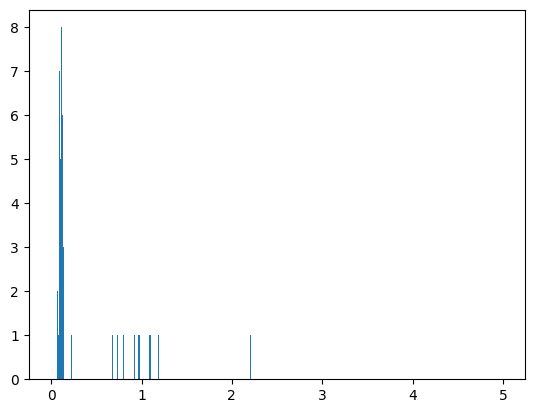

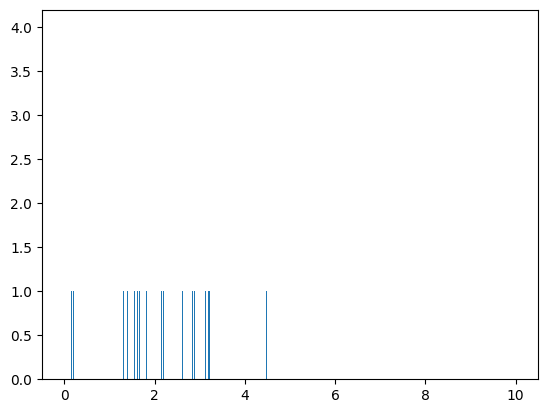

In [2]:
pBleft = sample[sample['event'].map(lambda x: 'pressed Button.left' in x)]
rBleft = sample[sample['event'].map(lambda x: 'released Button.left' in x)]

dt = rBleft['timestamp'].values - pBleft['timestamp'].values
plt.hist(dt, bins=np.arange(0.0, 5.0, 0.01))
plt.show()

pdt = pBleft['timestamp'].values[1:] - pBleft['timestamp'].values[:-1]
plt.hist(pdt, bins=np.arange(0.0, 10.0, 0.01))
plt.show()

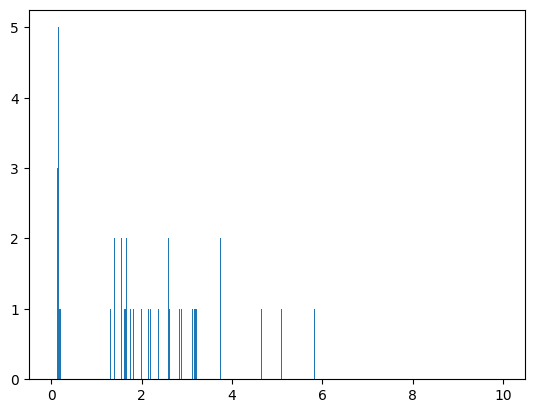

,timestamp,img_path,px,py,event,trajectory
25,41.167202,data/sample4/screen0000000025_41.1306256372481...,1774,48,pressed Button.left,NaN
29,43.902380,data/sample4/screen0000000029_43.8727909242734...,1672,164,pressed Button.left,NaN
33,46.026530,data/sample4/screen0000000033_45.9981662482023...,1789,42,pressed Button.left,NaN
37,47.748851,data/sample4/screen0000000037_47.7233962025493...,1671,170,pressed Button.left,NaN
41,49.314989,data/sample4/screen0000000041_49.2871536901220...,1787,46,pressed Button.left,NaN
47,54.072874,data/sample4/screen0000000047_54.0440859999507...,1598,405,pressed Button.left,NaN
51,55.788773,data/sample4/screen0000000051_55.7511396957561...,1596,47,pressed Button.left,NaN
55,57.627570,data/sample4/screen0000000055_57.5997267430648...,1501,412,pressed Button.left,NaN
59,59.118497,data/sample4/screen0000000059_59.0898985518142...,1505,51,pressed Button.left,NaN
63,60.409798,data/sample4/screen0000000063_60.3816529111936...,1493,410,pressed Button.left,NaN


In [4]:
pBleft = sample[sample['event'].map(lambda x: 'pressed Button.left' in x)]
pdt = pBleft['timestamp'].values[1:] - pBleft['timestamp'].values[:-1]
pdt = np.append(pdt, 1e10)
plt.hist(pdt, bins=np.arange(0.0, 10.0, 0.02))
plt.show()
pBleft.iloc[np.where(pdt <= 0.20)[0]]